<a href="https://colab.research.google.com/github/VIGNESHinZONE/Repurposing-Commercially-available-drugs-for-inhibition-of-the-coronavirus-using-Machine-Learning/blob/master/COVID_19_MODEL_with_DNN_%26_Inception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
cd gdrive/My Drive/SOVID - 19


/content/gdrive/.shortcut-targets-by-id/1FSDwqpFkKZ8yDznalDgKTEbZSsiUc4Wy/COVID - 19


# Importing Libraries

In [23]:
#General purpose libraries
import glob
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

#Torch Libraries for ANN
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

#Sklearn Libraries for Preprocessing
from sklearn import metrics
from sklearn.utils import shuffle
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA

%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [0]:
#seed
seed= 12321
random.seed(seed)  
np.random.seed(0)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

# Loading Data

In [25]:
data_train = pd.read_csv('Training_Data_SamR_700.csv').drop(['Unnamed: 0'],axis=1)
data_test = pd.read_csv('Testing_data.csv').drop(['Unnamed: 0'],axis=1)
data_active_test = data_test[data_test['Outcome']==1]
df_drug = pd.read_csv('Drugs.csv')

data_train.head()

,NEG_01_NEG,NEG_02_NEG,NEG_03_NEG,NEG_04_NEG,NEG_05_NEG,NEG_06_NEG,NEG_07_NEG,NEG_01_POS,NEG_02_POS,NEG_03_POS,NEG_04_POS,NEG_05_POS,NEG_06_POS,NEG_07_POS,NEG_01_HBD,NEG_02_HBD,NEG_03_HBD,NEG_04_HBD,NEG_05_HBD,NEG_06_HBD,NEG_07_HBD,NEG_01_HBA,NEG_02_HBA,NEG_03_HBA,NEG_04_HBA,NEG_05_HBA,NEG_06_HBA,NEG_07_HBA,NEG_01_ARC,NEG_02_ARC,NEG_03_ARC,NEG_04_ARC,NEG_05_ARC,NEG_06_ARC,NEG_07_ARC,NEG_01_HYP,NEG_02_HYP,NEG_03_HYP,NEG_04_HYP,NEG_05_HYP,...,HYP_01_HYP,HYP_02_HYP,HYP_03_HYP,HYP_04_HYP,HYP_05_HYP,HYP_06_HYP,HYP_07_HYP,WBN_GC_L_0.25,WBN_GC_H_0.25,WBN_GC_L_0.50,WBN_GC_H_0.50,WBN_GC_L_0.75,WBN_GC_H_0.75,WBN_GC_L_1.00,WBN_GC_H_1.00,WBN_EN_L_0.25,WBN_EN_H_0.25,WBN_EN_L_0.50,WBN_EN_H_0.50,WBN_EN_L_0.75,WBN_EN_H_0.75,WBN_EN_L_1.00,WBN_EN_H_1.00,WBN_LP_L_0.25,WBN_LP_H_0.25,WBN_LP_L_0.50,WBN_LP_H_0.50,WBN_LP_L_0.75,WBN_LP_H_0.75,WBN_LP_L_1.00,WBN_LP_H_1.00,XLogP,PSA,NumRot,NumHBA,NumHBD,MW,BBB,BadGroup,Outcome
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,-2.21896,1.89332,-2.33560,2.37617,-2.81410,3.18823,-3.64319,4.07620,-0.825457,1.36905,-1.69757,2.19638,-2.58817,3.09319,-3.48695,4.01060,-1.108000,1.15249,-1.84816,2.05047,-2.70698,2.96847,-3.59439,3.89453,1.111,90.29,9,5,1,369.421,0,1,0.0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,-2.05861,2.95213,-2.30022,3.16579,-2.79125,3.49171,-3.46407,4.01080,-0.774518,2.40204,-1.56260,2.67865,-2.35827,3.27843,-3.16100,4.16512,-1.080980,1.07652,-1.91118,1.92376,-2.75759,2.80998,-3.61043,3.71094,3.728,118.91,8,6,2,455.414,0,0,1.0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,-1.79896,1.23804,-1.94987,1.97407,-2.47040,2.79017,-3.16799,3.63023,-0.775963,1.24417,-1.55582,1.97668,-2.33738,2.80082,-3.11984,3.64791,-0.806244,1.15738,-1.45299,2.00033,-2.15199,2.85873,-2.87913,3.72070,3.332,42.43,3,3,0,269.324,1,0,1.0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,-1.53969,1.34274,-1.97551,2.07075,-2.75206,2.89920,-3.56623,3.75631,-0.781611,1.36371,-1.58847,2.14600,-2.41639,2.98943,-3.25765,3.85439,-1.035250,1.10898,-1.82384,1.92912,-2.66065,2.78327,-3.51047,3.65414,3.062,53.75,3,2,0,221.239,1,0,0.0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,-1.04825,1.35043,-1.62054,1.89552,-2.39049,2.55731,-3.17911,3.33711,-0.786468,1.30484,-1.57620,1.91242,-2.36748,2.62653,-3.15964,3.40169,-0.815247,1.11659,-1.40252,1.92860,-2.14519,2.74539,-2.92380,3.56424,6.358,50.41,4,3,2,313.470,1,4,1.0


In [0]:
Y_train = data_train[['Outcome']].to_numpy()
X_train = data_train.drop(['Outcome'],axis=1).to_numpy()


Y_test = data_test[['Outcome']].to_numpy()
X_test = data_test.drop(['Outcome'],axis=1).to_numpy()
X_test_active = data_active_test.drop(['Outcome'],axis=1).to_numpy()
data_inactive_test = data_test[data_test['Outcome']==0]
data_active_train = data_train[data_train['Outcome']==1]
data_inactive_train = data_train[data_train['Outcome']==0]
X_test_inactive = data_inactive_test.drop(['Outcome'],axis=1).to_numpy()
X_train_active = data_active_train.drop(['Outcome'],axis=1).to_numpy()
X_train_inactive = data_inactive_train.drop(['Outcome'],axis=1).to_numpy()

In [27]:
X_train.shape , Y_train.shape , X_train_active.shape , X_train_inactive.shape , Y_test.shape , X_test.shape , X_test_active.shape , X_test_inactive.shape

((538343, 179),
 (538343, 1),
 (248855, 179),
 (289488, 179),
 (1050, 1),
 (1050, 179),
 (50, 179),
 (1000, 179))

# PCA for data preprocessing

In [0]:
pca = PCA(n_components=128)
pca.fit(X_train)

X_train = pca.transform(X_train)
X_test = pca.transform(X_test)
X_test_active = pca.transform(X_test_active)
X_test_inactive = pca.transform(X_test_inactive)
X_train_active = pca.transform(X_train_active)
X_train_inactive = pca.transform(X_train_inactive)


# Nueral Networks

In [0]:
#Hyperparameters
activation = 'relu'
optimizer = 'Adam'
batch_size = 256
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
log_directory = "runs/logs1"
step = 0
writer = SummaryWriter(log_directory)

# Vanilla DNN

In [0]:
class Covid(nn.Module):
  def __init__(self):
    super(Covid, self).__init__()    
                               
    self.layer1 = nn.Sequential(nn.Linear(128,512),nn.ReLU(True))
    self.layer1_1 = nn.Sequential(nn.Linear(512,1024),nn.ReLU(True))
    self.layer2 = nn.Sequential(nn.Linear(1024,512),nn.ReLU(True))
    self.layer3 = nn.Sequential(nn.Linear(512,256),nn.ReLU(True))
    self.layer4 = nn.Sequential(nn.Linear(256,100),nn.ReLU(True))
    self.layer5 = nn.Sequential(nn.Linear(100,1),nn.Sigmoid())
    self.dropout = nn.Dropout(p=0.4)

  def forward(self,input):

    x = (self.layer1(input))
    x = self.dropout(self.layer1_1(x))
    x = self.dropout(self.layer2(x))
    x = self.dropout(self.layer3(x))
    x = self.dropout(self.layer4(x))
    x = self.layer5(x)

    return x

# Inception Convolution Network

In [0]:



class Covidcep(nn.Module):
  def __init__(self):
    super(Covidcep, self).__init__()
    
           
    self.layer1_1 =  nn.Sequential(nn.Conv1d(in_channels=1, out_channels=4, kernel_size=3,padding=1,stride=2),nn.ReLU(True))
    self.layer1_2 =  nn.Sequential(nn.Conv1d(1, 4, kernel_size=5,padding=2,stride=2),nn.ReLU(True))
    self.layer1_3 = nn.Sequential(nn.Conv1d(1, 4, kernel_size=1,padding=0,stride=1),nn.ReLU(True),nn.MaxPool1d(3,2,1))
    self.avgpool1 = nn.AvgPool1d(kernel_size=3,padding=1,stride=1)
    
    self.layer2_1 = m = nn.Sequential(nn.Conv1d(in_channels=12, out_channels=4, kernel_size=3,padding=1,stride=2),nn.ReLU(True))
    self.layer2_2 = m = nn.Sequential(nn.Conv1d(12, 4, kernel_size=5,padding=2,stride=2),nn.ReLU(True))
    self.layer2_3 = nn.Sequential(nn.Conv1d(12, 4, kernel_size=1,padding=0,stride=1),nn.ReLU(True),nn.MaxPool1d(3,2,1))
    self.avgpool2 = nn.AvgPool1d(kernel_size=3,padding=1,stride=1)
         
    self.layer3_1 = m = nn.Sequential(nn.Conv1d(in_channels=12, out_channels=3, kernel_size=3,padding=1,stride=2),nn.ReLU(True))
    self.layer3_2 = m = nn.Sequential(nn.Conv1d(12, 3, kernel_size=5,padding=2,stride=2),nn.ReLU(True))
    self.layer3_3 = nn.Sequential(nn.Conv1d(12, 3, kernel_size=1,padding=0,stride=1),nn.ReLU(True),nn.MaxPool1d(3,2,1))
    self.avgpool3 = nn.AvgPool1d(kernel_size=3,padding=1,stride=1)   
    
    self.layer4 = nn.Sequential(nn.Linear(144,10),nn.ReLU(True))
    self.layer5 = nn.Sequential(nn.Linear(10,1),nn.Sigmoid())

  def forward(self,x):
    
    x = torch.unsqueeze(x,1).float()
    x = self.avgpool1(torch.cat((self.layer1_1(x), self.layer1_2(x) ,self.layer1_3(x)), 1) )
    x = self.avgpool2(torch.cat((self.layer2_1(x), self.layer2_2(x),self.layer2_3(x)), 1) )
    x = self.avgpool3(torch.cat((self.layer3_1(x), self.layer3_2(x),self.layer3_3(x)), 1) )
    x = x.view(x.size(0),-1).float()
    x = self.layer4(x)
    x = self.layer5(x)   
    
    return x


# Additional Utility Functions

In [0]:

class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=3, weight=5 , logits=False, reduce=False ):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.weight = weight
        self.reduce = reduce

    def forward(self, inputs, targets):
        if self.logits:
            BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduce=False)
        else:
            BCE_loss = F.binary_cross_entropy(inputs, targets, reduce=False , weight=targets*self.weight + 1)
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduce:
            return torch.mean(F_loss)
        else:
            return torch.sum(F_loss)

def train(epoch,train_loader,writer):
  model.train()
  for p in model.parameters():
    p.requires_grad = True

  train_loss = 0.0
  running_loss = 0.0
  running_total = 0.0
  running_accuracy = 0.0
  total = 0.0
  accuracy = 0.0
  step = 1
  print("==================================Train==================================")
  for i,data in enumerate(train_loader):
    

    model.zero_grad()
    X_real,Y_real = data
    X_real = X_real.to(device).float()
    Y_real = Y_real.to(device).float()
    b_size = X_real.size(0)
    output = model(X_real.float()).float()
    
    loss = criterion(output.float(), Y_real.float())
    loss.backward()
    train_loss += loss.item()
    running_loss += loss.item()
    total += b_size
    running_total += b_size


    #accuracy
    acc = ((Y_real == 1)==((output) > 0.5))
    acc = acc.sum().item()
    accuracy += acc
    running_accuracy += acc
    optimizer.step()

    if i% 100 == 0 and i!=0:
      Tloss,_,_ = test(epoch,test_loader,p = False)
      writer.add_scalar('Training_Loss ',
                            running_loss/100,
                            step )
      
      writer.add_scalar('Test_Loss ',
                            running_accuracy/running_total,
                            step )
      running_loss = 0.0
      running_total = 0.0
      running_accuracy = 0.0
      step+=1

    if i% 500 == 0 and i!=0:
      print('[%d/%d][%d/%d]\tLoss_train: %.4f\tTrain_Accuracy: %.4f'
                  % (epoch, num_epochs, i, len(train_loader),
                     loss.item(), acc/b_size))
  output = (model(torch.from_numpy(X_train_active).to(device).float())) > 0.5
  print("Train Active accuracy" , output.sum().item()/ output.size(0),"<---------------")
  output = (model(torch.from_numpy(X_train_inactive).to(device).float())) < 0.5
  print("Train Inactive accuracy" , output.sum().item()/ output.size(0))
  print("=========================================================================")
  return train_loss , accuracy/total ,total


def test(epoch,test_loader,p = True):
    model.eval()
    test_loss = 0.0
    total = 0.0
    accuracy = 0.0
    if p:
      print("==================================Test==================================")

    for i,data in enumerate(test_loader):
      X_real,Y_real = data
      X_real = X_real.to(device)
      Y_real = Y_real.to(device)
      b_size = X_real.size(0)
      output = model(X_real.float()).float()
      loss = criterion(output.float(), Y_real.float())
      test_loss += loss.item()
      total += b_size

      acc = ((Y_real == 1)==((output) > 0.5))
      acc = acc.sum().item() / b_size
      accuracy += acc

      if i% 3 == 0 and i!=0 and p:
        print('[%d/%d][%d/%d]\tLoss_test: %.4f\tTest_Accuracy: %.4f'
                  % (epoch, num_epochs, i, len(test_loader),
                     loss.item(), acc))
      

    output = (model(torch.from_numpy(X_test_active).to(device).float())) > 0.5
    if p:
      print("Test Active accuracy" , output.sum().item()/ output.size(0),"<---------------")
    output = (model(torch.from_numpy(X_test_inactive).to(device).float())) < 0.5
    if p:
      print("Test Inactive accuracy" , output.sum().item()/ output.size(0))
      print("=========================================================================")
    return test_loss,accuracy,total


def compute_roc(y_true, y_pred, plot=True):
    """
    TODO
    :param y_true: ground truth
    :param y_pred: predictions
    :param plot:
    :return:
    """
    fpr, tpr, _ = metrics.roc_curve(y_true, y_pred)
    auc_score = metrics.auc(fpr, tpr)
    if plot:
        plt.figure(figsize=(7, 6))
        plt.plot(fpr, tpr, color='blue',
                 label='ROC (AUC = %0.4f)' % auc_score)
        plt.legend(loc='lower right')
        plt.title("ROC Curve")
        plt.xlabel("FPR")
        plt.ylabel("TPR")
        plt.show()

    return fpr, tpr, auc_score 

def drug_checker(arr,conf):
  ls = [1082,928,115,1260,794,573,1133,383,1112,1919,1918,1750]
  for e in  ls:
    if e in arr:
      print( "Drug number ", e , " score ", conf[e])

def drug_checker_all(arr,conf):
  ls = [1082,928,115,1260,794,573,1133,383,1112,1919,1918,1750]
  for e in  ls:
    
      print( "Drug number ", e , " score ", conf[e])

                  






In [0]:
train_dataset = torch.utils.data.TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(Y_train).float())
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

test_dataset = torch.utils.data.TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(Y_test).float())
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Training
## Vanilla DNN with BCELoss

In [34]:
num_epochs = 2
torch.manual_seed(seed)
torch.set_default_dtype(torch.float32)
model = Covid()
model = model.to(device).float()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(),lr = 5e-5)

for epoch in range(0, num_epochs ):
    a, _,c = train(epoch,train_loader,writer)
    i,_,e = test(epoch,test_loader)
    
model.eval()
X_drug = df_drug.drop(['Outcome'],axis=1).to_numpy()
X_drug = pca.transform(X_drug)

output = (model(torch.from_numpy(X_drug).to(device).float())) > 0.5
print( "drugs",output.sum().item())

==================================Train==================================
[0/2][500/2103]	Loss_train: 0.5783	Train_Accuracy: 0.7070
[0/2][1000/2103]	Loss_train: 0.4921	Train_Accuracy: 0.7461
[0/2][1500/2103]	Loss_train: 0.4013	Train_Accuracy: 0.8086
[0/2][2000/2103]	Loss_train: 0.3356	Train_Accuracy: 0.8398
Train Active accuracy 0.9690140845070423 <---------------
Train Inactive accuracy 0.8080334936163157
==================================Test==================================
[0/2][3/5]	Loss_test: 0.4400	Test_Accuracy: 0.8320
Test Active accuracy 0.64 <---------------
Test Inactive accuracy 0.79
==================================Train==================================
[1/2][500/2103]	Loss_train: 0.2624	Train_Accuracy: 0.9102
[1/2][1000/2103]	Loss_train: 0.1429	Train_Accuracy: 0.9609
[1/2][1500/2103]	Loss_train: 0.1845	Train_Accuracy: 0.9297
[1/2][2000/2103]	Loss_train: 0.1337	Train_Accuracy: 0.9414
Train Active accuracy 0.9971830985915493 <---------------
Train Inactive accuracy 0.91

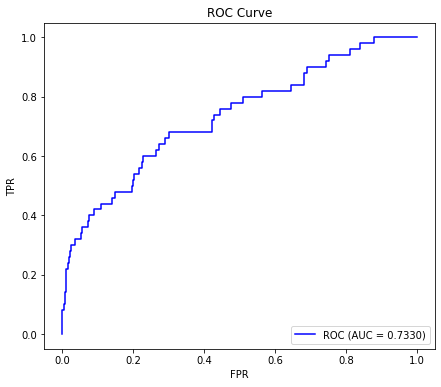

In [35]:
_,_,_=compute_roc(Y_test,model(torch.from_numpy(X_test).to(device).float()).cpu().detach().numpy())

In [36]:
ans = output.cpu().detach().numpy()
result = np.where(ans == True)
drug_df = pd.read_csv('Drug1.csv')
list_df = drug_df[['DRUGBANK_ID']]
list_df = list_df.iloc[result[0].tolist()]
conf = model(torch.from_numpy(X_drug).to(device).float()).cpu().detach().numpy()
drug_checker(result[0],conf)

Drug number  928  score  [0.9994011]
Drug number  1260  score  [0.9896063]
Drug number  573  score  [0.8190205]
Drug number  383  score  [0.9999453]
Drug number  1112  score  [0.8803262]
Drug number  1918  score  [0.99996555]
Drug number  1750  score  [0.9999145]


# Vanilla DNN with weighted Focal loss

In [43]:
num_epochs = 3
torch.manual_seed(seed)
torch.set_default_dtype(torch.float32)
model = Covid()
model = model.to(device).float()
criterion = FocalLoss()
optimizer = optim.Adam(model.parameters(),lr = 5e-5)

for epoch in range(0, num_epochs ):
    a, _,c = train(epoch,train_loader,writer)
    i,_,e = test(epoch,test_loader)
    
model.eval()
X_drug = df_drug.drop(['Outcome'],axis=1).to_numpy()
X_drug = pca.transform(X_drug)

output = (model(torch.from_numpy(X_drug).to(device).float())) > 0.5
print( "drugs",output.sum().item())

==================================Train==================================


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


[0/3][500/2103]	Loss_train: 137.4862	Train_Accuracy: 0.5273
[0/3][1000/2103]	Loss_train: 121.3252	Train_Accuracy: 0.5039
[0/3][1500/2103]	Loss_train: 96.5706	Train_Accuracy: 0.6523
[0/3][2000/2103]	Loss_train: 86.5863	Train_Accuracy: 0.7539
Train Active accuracy 1.0 <---------------
Train Inactive accuracy 0.6110961421544243
==================================Test==================================
[0/3][3/5]	Loss_test: 96.0512	Test_Accuracy: 0.5781
Test Active accuracy 0.74 <---------------
Test Inactive accuracy 0.584
==================================Train==================================
[1/3][500/2103]	Loss_train: 45.5133	Train_Accuracy: 0.8594
[1/3][1000/2103]	Loss_train: 26.2961	Train_Accuracy: 0.9023
[1/3][1500/2103]	Loss_train: 34.3761	Train_Accuracy: 0.9062
[1/3][2000/2103]	Loss_train: 25.3864	Train_Accuracy: 0.9062
Train Active accuracy 1.0 <---------------
Train Inactive accuracy 0.8594034985906152
==================================Test==================================
[1/3

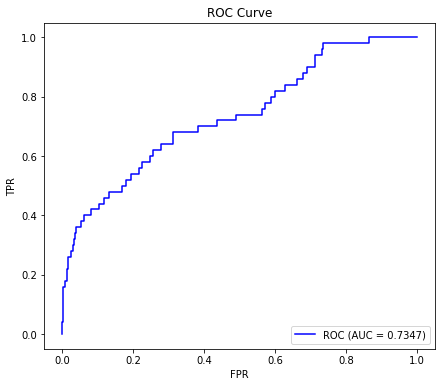

In [44]:
_,_,_=compute_roc(Y_test,model(torch.from_numpy(X_test).to(device).float()).cpu().detach().numpy())

In [45]:
ans = output.cpu().detach().numpy()
result = np.where(ans == True)
drug_df = pd.read_csv('Drug1.csv')
list_df = drug_df[['DRUGBANK_ID']]
list_df = list_df.iloc[result[0].tolist()]
conf = model(torch.from_numpy(X_drug).to(device).float()).cpu().detach().numpy()
drug_checker(result[0],conf)

Drug number  928  score  [0.9996351]
Drug number  1260  score  [0.986099]
Drug number  573  score  [0.93566203]
Drug number  383  score  [0.9998247]
Drug number  1112  score  [0.97640413]
Drug number  1918  score  [0.9993851]
Drug number  1750  score  [0.9959188]


# Inception Network with BCE_loss

In [40]:
num_epochs = 4
torch.manual_seed(seed)
torch.set_default_dtype(torch.float32)
model = Covidcep()
model = model.to(device).float()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(),lr = 5e-5)

for epoch in range(0, num_epochs ):
    a, _,c = train(epoch,train_loader,writer)
    i,_,e = test(epoch,test_loader)
    
model.eval()
X_drug = df_drug.drop(['Outcome'],axis=1).to_numpy()
X_drug = pca.transform(X_drug)

output = (model(torch.from_numpy(X_drug).to(device).float())) > 0.5
print( "drugs",output.sum().item())

==================================Train==================================
[0/4][500/2103]	Loss_train: 0.6717	Train_Accuracy: 0.6055
[0/4][1000/2103]	Loss_train: 0.6794	Train_Accuracy: 0.5742
[0/4][1500/2103]	Loss_train: 0.6791	Train_Accuracy: 0.5625
[0/4][2000/2103]	Loss_train: 0.6560	Train_Accuracy: 0.6289
Train Active accuracy 0.36056338028169016 <---------------
Train Inactive accuracy 0.8108868070524512
==================================Test==================================
[0/4][3/5]	Loss_test: 0.5986	Test_Accuracy: 0.7617
Test Active accuracy 0.5 <---------------
Test Inactive accuracy 0.783
==================================Train==================================
[1/4][500/2103]	Loss_train: 0.6499	Train_Accuracy: 0.5938
[1/4][1000/2103]	Loss_train: 0.6783	Train_Accuracy: 0.5742
[1/4][1500/2103]	Loss_train: 0.6672	Train_Accuracy: 0.5703
[1/4][2000/2103]	Loss_train: 0.6555	Train_Accuracy: 0.6250
Train Active accuracy 0.36901408450704226 <---------------
Train Inactive accuracy 0.

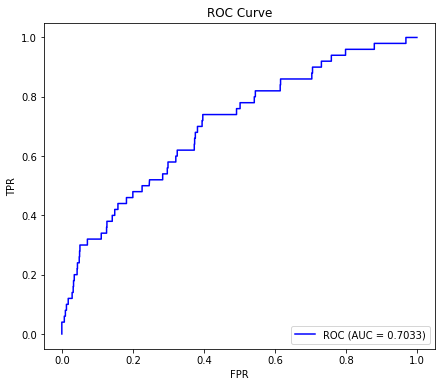

In [41]:
_,_,_=compute_roc(Y_test,model(torch.from_numpy(X_test).to(device).float()).cpu().detach().numpy())

In [42]:
ans = output.cpu().detach().numpy()
result = np.where(ans == True)
drug_df = pd.read_csv('Drug1.csv')
list_df = drug_df[['DRUGBANK_ID']]
list_df = list_df.iloc[result[0].tolist()]
conf = model(torch.from_numpy(X_drug).to(device).float()).cpu().detach().numpy()
drug_checker(result[0],conf)

Drug number  1082  score  [0.81924504]
Drug number  928  score  [0.9250704]
Drug number  115  score  [0.60907644]
Drug number  1260  score  [0.68611497]
Drug number  573  score  [0.56763256]
Drug number  1133  score  [0.5014511]
Drug number  383  score  [0.93591195]
Drug number  1112  score  [0.6336284]
Drug number  1919  score  [0.9630061]
Drug number  1918  score  [0.9759523]
Drug number  1750  score  [0.9666844]
